## **Activity 13.01 – Creating a time series model**

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

2. Read in the bike_share.csv data from the Datasets directory, and list the
first few rows:

In [2]:
!wget https://raw.githubusercontent.com/PacktWorkshops/The-Pandas-Workshop/master/Chapter13/Datasets/bike_share.csv

--2023-07-10 00:17:20--  https://raw.githubusercontent.com/PacktWorkshops/The-Pandas-Workshop/master/Chapter13/Datasets/bike_share.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.108.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 278650 (272K) [text/plain]
Saving to: ‘bike_share.csv’

bike_share.csv      100%[===================>] 272.12K  --.-KB/s    in 0.03s   

2023-07-10 00:17:20 (7.82 MB/s) - ‘bike_share.csv’ saved [278650/278650]



In [3]:
bike_share = pd.read_csv('bike_share.csv')

bike_share.head()

,date,hour,rentals
0,1/1/2011,0,16
1,1/1/2011,1,40
2,1/1/2011,2,32
3,1/1/2011,3,13
4,1/1/2011,4,1


In [4]:
bike_share.dtypes

date       object
hour        int64
rentals     int64
dtype: object

3. You need to create a datetime index. Construct a new datetime-valued column as a combination of the date and the hour and make it the index:

In [5]:
# bike_share.set_index(bike_share['date'])

# bike_share['date'] = pd.to_datetime(bike_share['date'], format = '%M-%D-%Y')
# bike_share['hour'] = pd.to_datetime(bike_share['hour'], format = '{:00:00}')
# bike_share['date_time'] = [(bike_share['date'] + bike_share['hour'])]

# bike_share['date_time'] = [(bike_share.date[i] + ' ' + '{:02}'.format(bike_share.hour[i] + ':00:00') for i in bike_share.index)]

bike_share['date_time'] = \
[(bike_share.date[i] +  ' ' + '{:02}'.format(bike_share.hour[i]) + ':00:00')
 for i in bike_share.index]
bike_share.set_index(pd.to_datetime(bike_share['date_time']),
                     inplace = True,
                     drop = True)
bike_share

# bike_share.set_index(pd.to_datetime(bike_share['date_time']),
#                      inplace = True,
#                      drop = True)

bike_share

,date,hour,rentals,date_time
date_time,,,,
2011-01-01 00:00:00,1/1/2011,0,16,1/1/2011 00:00:00
2011-01-01 01:00:00,1/1/2011,1,40,1/1/2011 01:00:00
2011-01-01 02:00:00,1/1/2011,2,32,1/1/2011 02:00:00
2011-01-01 03:00:00,1/1/2011,3,13,1/1/2011 03:00:00
2011-01-01 04:00:00,1/1/2011,4,1,1/1/2011 04:00:00
...,...,...,...,...
2012-12-31 19:00:00,12/31/2012,19,119,12/31/2012 19:00:00
2012-12-31 20:00:00,12/31/2012,20,89,12/31/2012 20:00:00
2012-12-31 21:00:00,12/31/2012,21,90,12/31/2012 21:00:00


4. Generate a simple plot of the data versus time:

<Axes: xlabel='date_time'>

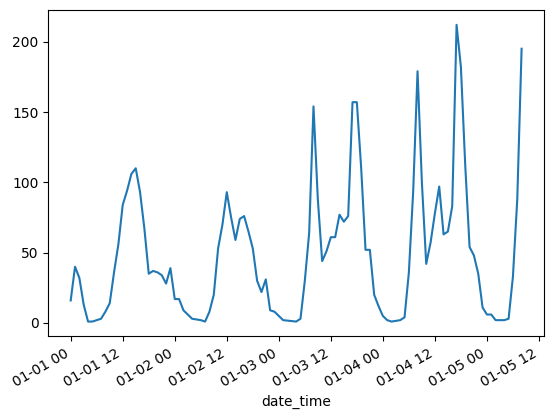

In [6]:
bike_share['rentals'][:100].plot()

5. Using the index and the rentals column, downsample the data to 1-day intervals. You want total rentals per day, so choose the appropriate aggregation function:

In [7]:
bike_share = pd.DataFrame(bike_share['rentals'].resample('1d').sum())

# sum so you can get the total per day

bike_share

,rentals
date_time,
2011-01-01,985
2011-01-02,801
2011-01-03,1349
2011-01-04,1562
2011-01-05,1600
...,...
2012-12-27,2114
2012-12-28,3095
2012-12-29,1341


6. Generate a simple plot of the first 8 weeks (56 days) of the resampled data:

<Axes: xlabel='date_time'>

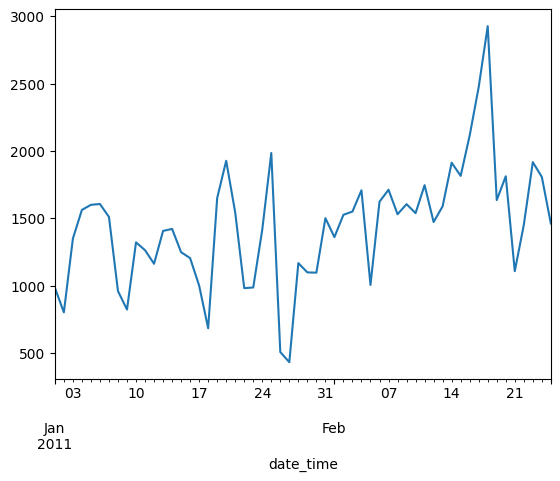

In [8]:
bike_share['rentals'][:56].plot()

7. You should notice there are ups and downs that seem to be on about a 7-day cycle. Explore this by plotting the data versus itself, shifted appropriately:

In [9]:
bike_share.shape

(731, 1)

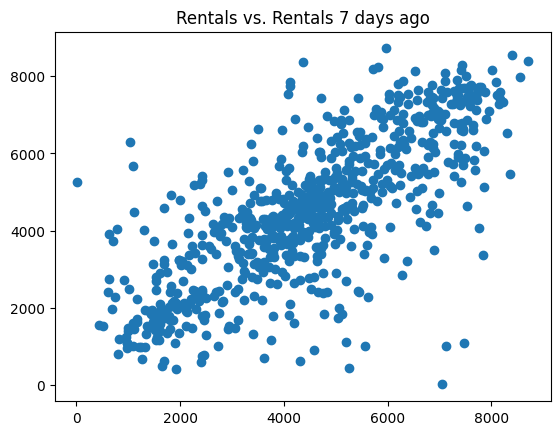

In [10]:
fig, ax = plt.subplots()

ax.scatter(bike_share['rentals'][:(bike_share.shape[0] - 7)],
           bike_share['rentals'][7:])
ax.set_title('Rentals vs. Rentals 7 days ago')

plt.show()

8. Preparing to apply linear regression to the data in Figure 13.31, create a new column with shifted data:

In [11]:
shifted_rentals = bike_share['rentals'][:(bike_share.shape[0] - 7)]
shifted_rentals.index = bike_share.index[7:]
bike_share['shifted_rentals'] = shifted_rentals
bike_share

,rentals,shifted_rentals
date_time,,
2011-01-01,985,NaN
2011-01-02,801,NaN
2011-01-03,1349,NaN
2011-01-04,1562,NaN
2011-01-05,1600,NaN
...,...,...
2012-12-27,2114,4128.0
2012-12-28,3095,3623.0
2012-12-29,1341,1749.0


9. Now, use the LinearRegression module to fit a linear model, using the lagged
data as the X data, and the actual rentals as the Y data:

In [12]:
lin_model = bike_share.copy()[bike_share['shifted_rentals'].isna() == False]
shifted_model = LinearRegression()

shifted_model.fit(lin_model['shifted_rentals'].values.reshape(-1, 1),
                  lin_model['rentals'].values.reshape(-1, 1))

lin_model['predicted'] = shifted_model.predict(lin_model['shifted_rentals'].values.reshape(-1, 1))

R2 = shifted_model.score(lin_model['rentals'].values.reshape(-1, 1),
                         lin_model['predicted'].values.reshape(-1, 1))

print('R2 is ', R2, ' using:')
print(lin_model[['rentals', 'shifted_rentals']].head())


R2 is  0.5145071365683822  using:
            rentals  shifted_rentals
date_time                           
2011-01-08      959            985.0
2011-01-09      822            801.0
2011-01-10     1321           1349.0
2011-01-11     1263           1562.0
2011-01-12     1162           1600.0


10. Plot the predicted values versus the actual values and compare them to an ideal prediction:

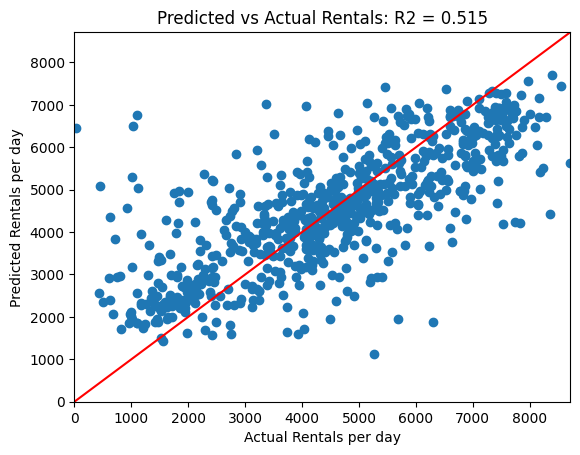

In [13]:
fig, ax = plt.subplots()

ax.scatter(lin_model['rentals'], lin_model['predicted'])
xlim = (0, max(pd.concat([
    lin_model['predicted'],
    lin_model['rentals']
])))
ylim = xlim

ax.set_xlim(xlim)
ax.set_ylim(ylim)

ax.plot(
    [xlim[0], xlim[1]],
    [ylim[0], ylim[1]],
    color = 'red'
)

ax.set_title('Predicted vs Actual Rentals: R2 = ' + str(round(R2, 3)))
ax.set_xlabel('Actual Rentals per day')
ax.set_ylabel('Predicted Rentals per day')

plt.show()